# 04-09

## Challenge 02 - Electricity Consumption Prediction

---

![](https://images.unsplash.com/photo-1521618755572-156ae0cdd74d?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1656&q=80)
Photo by [Zbynek Burival](https://unsplash.com/photos/V4ZYJZJ3W4M)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#I.-Key-concepts-in-time-series" data-toc-modified-id="I.-Key-concepts-in-time-series-1">I. Key concepts in time series</a></span></li><li><span><a href="#III.-Decomposition-and-forecasting" data-toc-modified-id="III.-Decomposition-and-forecasting-2">III. Decomposition and forecasting</a></span><ul class="toc-item"><li><span><a href="#1.-Trends" data-toc-modified-id="1.-Trends-2.1">1. Trends</a></span></li><li><span><a href="#2.-Seasonality" data-toc-modified-id="2.-Seasonality-2.2">2. Seasonality</a></span></li><li><span><a href="#3.-Automatic-Decomposition" data-toc-modified-id="3.-Automatic-Decomposition-2.3">3. Automatic Decomposition</a></span></li><li><span><a href="#4.-Model-the-stationary-series" data-toc-modified-id="4.-Model-the-stationary-series-2.4">4. Model the stationary series</a></span><ul class="toc-item"><li><span><a href="#Moving-Average-(MA)-processes" data-toc-modified-id="Moving-Average-(MA)-processes-2.4.1">Moving Average (MA) processes</a></span></li><li><span><a href="#Auto-Regressive-(AR)-processes" data-toc-modified-id="Auto-Regressive-(AR)-processes-2.4.2">Auto Regressive (AR) processes</a></span></li><li><span><a href="#Auto-Regressive-Moving-Average-(ARMA)-processes" data-toc-modified-id="Auto-Regressive-Moving-Average-(ARMA)-processes-2.4.3">Auto Regressive Moving Average (ARMA) processes</a></span></li><li><span><a href="#Auto-Regressive-Integrated-Moving-Average-(ARIMA)-processes" data-toc-modified-id="Auto-Regressive-Integrated-Moving-Average-(ARIMA)-processes-2.4.4">Auto Regressive Integrated Moving Average (ARIMA) processes</a></span></li><li><span><a href="#Seasonal-Autoregressive-Integrated-Moving-Average-(SARIMA)-process" data-toc-modified-id="Seasonal-Autoregressive-Integrated-Moving-Average-(SARIMA)-process-2.4.5">Seasonal Autoregressive Integrated Moving-Average (SARIMA) process</a></span></li><li><span><a href="#Time-series-recomposition" data-toc-modified-id="Time-series-recomposition-2.4.6">Time series recomposition</a></span></li></ul></li><li><span><a href="#5.-Using-Prophet" data-toc-modified-id="5.-Using-Prophet-2.5">5. Using Prophet</a></span></li></ul></li></ul></div>

In this exercise, you will be asked to use insights from the previous exploration, and build forecasts for the electricity consumption.

You will be working with time series of Open Power System Data ([OPSD](https://open-power-system-data.org/)) for Germany. 

The data set includes daily electricity consumption, wind power production, and solar power production between 2006 and 2017. 
```
- Date — The date (yyyy-mm-dd format)
- Consumption — Electricity consumption in GWh
- Wind — Wind power production in GWh
- Solar — Solar power production in GWh
- Wind+Solar — Sum of wind and solar power production in GWh
```

In [1]:
# Imports
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime as d

import statsmodels.api as sm

import matplotlib.pyplot as plt

import seaborn as sns

import plotly.express as px

In [2]:
# Load file
df = pd.read_csv('opsd_germany_daily.csv')

## I. Key concepts in time series

For what comes next, we will only focus on the consumption (and the prediction of the consumption). 

Q1 - Plot the autocorrelation and partial autocorrelation of the consumption. What do you notice ?

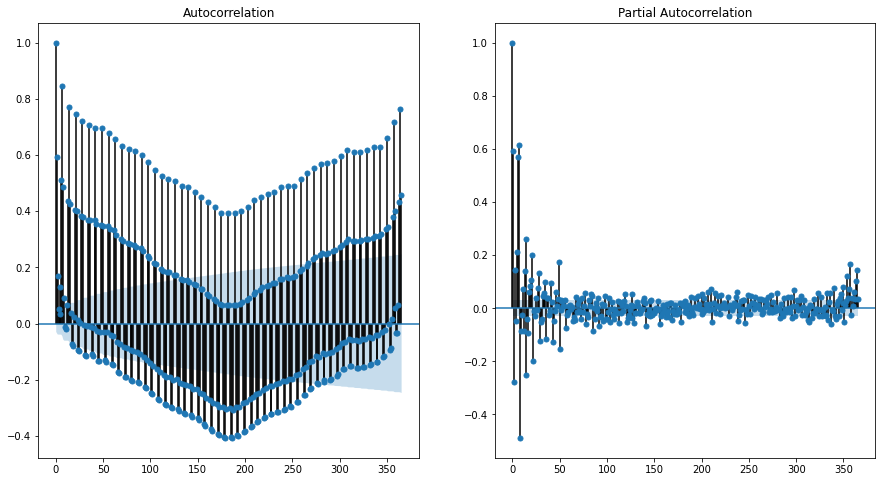

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(15,8))

fig = sm.graphics.tsa.plot_acf(df['Consumption'], lags=365, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(df['Consumption'], lags=365, ax=axes[1])

Q2 - Is the series stationary ? 

In [4]:
# ADFuller 
result = adfuller(df['Consumption'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.239148
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


**The series is stationary.**

Q3 - Can you thing of any technique that could help our future model be more precise ?

## III. Decomposition and forecasting

### 1. Trends

Q4 - Try to apply de-trending. Is it interesting ? 

In [5]:
# LinearRegression

In [6]:
from sklearn.linear_model import LinearRegression

X = np.array(range(len(df['Consumption'])))
y = np.log(df['Consumption'])

reg = LinearRegression().fit(X.reshape(-1,1), y)
pred_lin = reg.predict(X.reshape(-1,1))

In [7]:
# polyfit & log trend + exp trend
a_1,b_1 = np.polyfit(np.log(X+1), y, 1)
a_2,b_2 = np.polyfit(X+1, np.log(y), 1)

In [8]:
pred_log = a_1 * np.log(X+1) + b_1
pred_exp = np.exp(b_2) + np.exp( (X+1) * a_2)

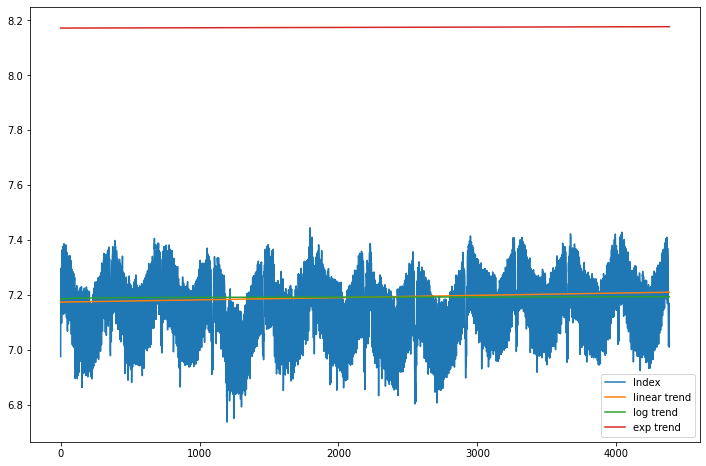

In [9]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(np.log(df['Consumption']), label="Index")
plt.plot(df['Consumption'].index, pred_lin, label="linear trend")
plt.plot(df['Consumption'].index, pred_log, label="log trend")
plt.plot(df['Consumption'].index, pred_exp, label="exp trend")
plt.legend()
plt.show()

We will apply a log transform for what comes next :

In [10]:
series = np.log(df['Consumption'])

In [11]:
type(series)

pandas.core.series.Series

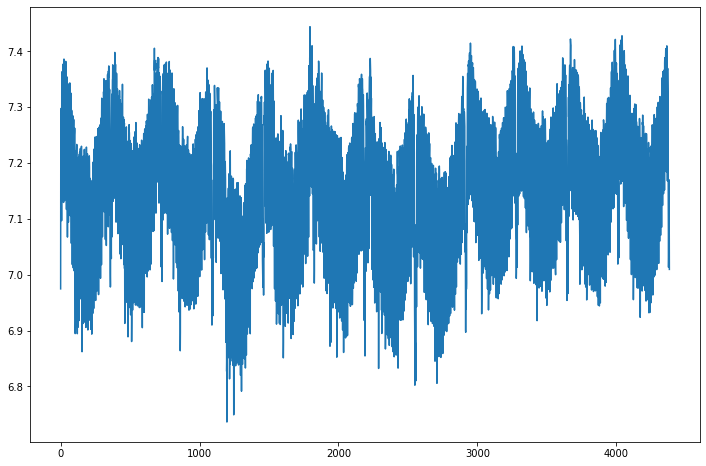

In [12]:
plt.figure(figsize=(12,8))
plt.plot(series)
plt.show()

In [13]:
# ADFuller 
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.287039
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


### 2. Seasonality

Q5 - Try to remove the seasonality. Is it interesting ? 

If we observe some seasonality over a year, the easiest option to remove the trend is to compute the first difference. For example, if there is a yearly seasonality, we can take $ y_t $ - $ y_{t-365} $

In [14]:
from scipy.ndimage.interpolation import shift

In [15]:
# series
series_shifted = shift(series, 365, mode='reflect')

In [16]:
series_shifted

array([7.04263401, 7.1210513 , 7.15042377, ..., 7.1669584 , 7.16320647,
       7.1004957 ])

In [17]:
series_diff = series-series_shifted

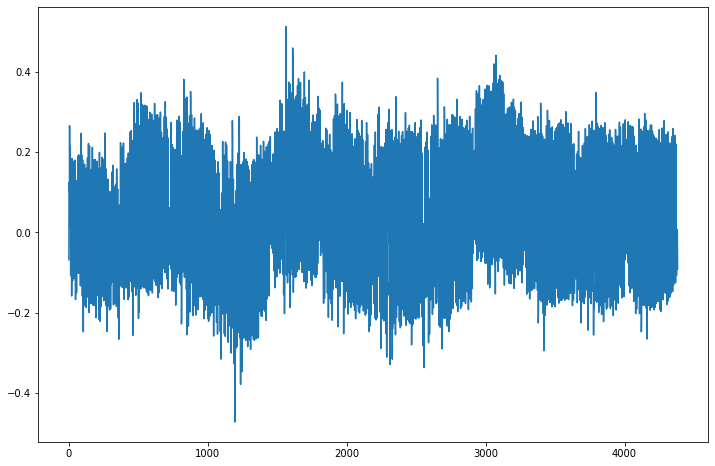

In [18]:
# plot
plt.figure(figsize=(12,8))
plt.plot(series_diff)
plt.show()

In [19]:
# ADFuller 
result = adfuller(series_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.818644
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Q6 - How does the ADFuller test compare now ? Did you improve anything ?

The seasonality removal did not improve anything.

### 3. Automatic Decomposition

Q7 - Does the automatic decomposition of `statsmodels` identify anything else ?

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
# decomposition
decomposition = seasonal_decompose(series, period=365, extrapolate_trend='freq')

We set the frequency to 365 in this case since we observe a recurrent pattern over 365 days.

<Figure size 432x288 with 0 Axes>

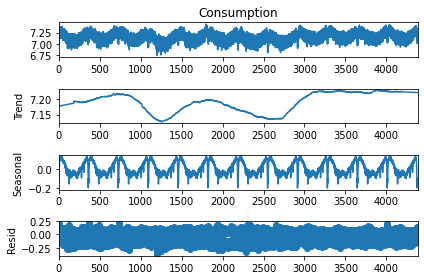

In [21]:
# plot
plt.figure()
decomposition.plot()
plt.show()

### 4. Model the stationary series

Q8 - Taking years of training data is not always the best idea. Based on the decomposition above, what time frame seems the most relevant ?

In [22]:
series[2:]

2       7.274156
3       7.284284
4       7.297857
5       7.246672
6       7.170340
          ...   
4378    7.141990
4379    7.170015
4380    7.166334
4381    7.102869
4382    7.009513
Name: Consumption, Length: 4381, dtype: float64

In [23]:
size = int(df.shape[0]*0.8)
train_series = series[:size]
test_series = series[size:]
test_series = test_series.reset_index()['Consumption']

#### Moving Average (MA) processes

Q9 - Apply a Moving Average process on 20 % of test data. Comment your results.

In [24]:
from sklearn.metrics import mean_squared_error

# train, test & history
history = [x for x in train_series]
predictions = []

In [26]:
# walk forward over time steps in test
for t in range(len(test_series)):
    model = ARMA(history, order=(0,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_series[t]
    history.append(yhat)

/home/guillaume/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/guillaume/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


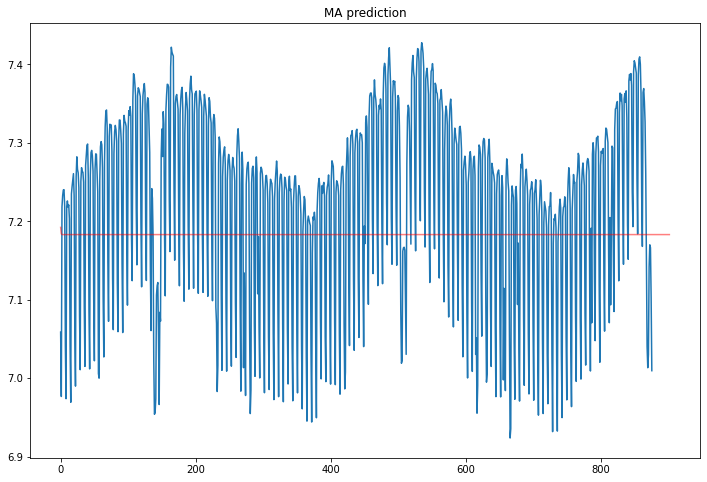

In [27]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(test_series)
plt.title("MA prediction")
plt.plot(predictions, color='red',alpha=0.5)
plt.show()

Zoom on the prediction :

In [ ]:
# Zoom

In [28]:
# MSE
mean_squared_error(predictions, test_series)

ValueError: Found input variables with inconsistent numbers of samples: [903, 877]

#### Auto Regressive (AR) processes

Q10 - Apply an Auto Regressive process on 20 % of test data. Comment your results.

In [ ]:
history = [x for x in train_series]
predictions = []

In [ ]:
for t in range(len(test_series)):
    model = ARMA(history, order=(2,0))
    model_fit = model.fit(disp=0)
    output = model_fit.predict()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_series[t]
    history.append(yhat)

In [ ]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(test_series)
plt.title("AR prediction")
plt.plot(predictions, color='red',alpha=0.5)
plt.show()

In [ ]:
# Zoom

The AR model is not performing well.

In [ ]:
# MSE
mean_squared_error(predictions, test_series)

#### Auto Regressive Moving Average (ARMA) processes

Q11 - Apply an Auto Regressive Moving Average process on 20 % of test data. Comment your results.

In [ ]:
history = [x for x in train_series]
predictions = []

In [ ]:
for t in range(len(test_series)):
    model = ARMA(history, order=(1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.predict()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_series[t]
    history.append(yhat)

In [ ]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(test_series)
plt.title("ARMA prediction")
plt.plot(predictions, color='red',alpha=0.5)
plt.show()

Zoom on the prediction :

In [ ]:
# Zoom

In [ ]:
# MSE
mean_squared_error(predictions, test_series)

#### Auto Regressive Integrated Moving Average (ARIMA) processes

Q12 - Apply an Auto Regressive Integrated Moving Average process on 5 % of test data. Comment your results.

In [ ]:
size = int(df.shape[0]*0.95)
train_series = series[:size]
test_series = series[size:]
test_series = test_series.reset_index()['Consumption']

In [ ]:
history = [x for x in train_series]
predictions = []

In [ ]:
for t in range(len(test_series)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.predict()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_series[t]
    history.append(yhat)

In [ ]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(test_series)
plt.title("ARIMA prediction")
plt.plot(predictions, color='red',alpha=0.5)
plt.show()

Zoom on the prediction :

In [ ]:
# Zoom

In [ ]:
# MSE
mean_squared_error(predictions, test_series)

#### Seasonal Autoregressive Integrated Moving-Average (SARIMA) process

Q13 - There is a seasonal pattern over time that we cannot remove. SARIMA might help ! Fit and predict with a SARIMA model on 80% of the data.

In [29]:
size = int(df.shape[0]*0.80)
train_series = series[:size]
test_series = series[size:]
test_series = test_series.reset_index()['Consumption']

In [30]:
history = [x for x in train_series]
predictions = []

In [31]:
for t in range(len(test_series)):
    model = SARIMAX(history, order=(1,1,1), seasonal_order=(1,1,1, 7))
    model_fit = model.fit(disp=0)
    output = model_fit.predict()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_series[t]
    history.append(yhat)

/home/guillaume/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/guillaume/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/guillaume/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/guillaume/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/guillaume/.pyenv/v

KeyboardInterrupt: 

In [ ]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(t est_series)
plt.title("SARIMAX prediction")
plt.plot(predictions, color='red',alpha=0.5)
plt.show()

Zoom on the prediction :

In [ ]:
# Zoom

In [ ]:
# MSE

#### Time series recomposition

Q14 - Now that you identified the best model, build the prediction by recomposing the time series !

In [ ]:
# Plot

### 5. Using Prophet

Q15 - Apply a model with Prophet. Comment your results.

In [22]:
# Plot